#### Importations

In [82]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from yolo_dataset_stats import DatasetAnalyzer
import matplotlib.pyplot as plt
import random
from math import sin, cos, radians
import yaml
import matplotlib.patheffects as PathEffects
from io import BytesIO
from PIL import Image

## L-System inspired tree generator 

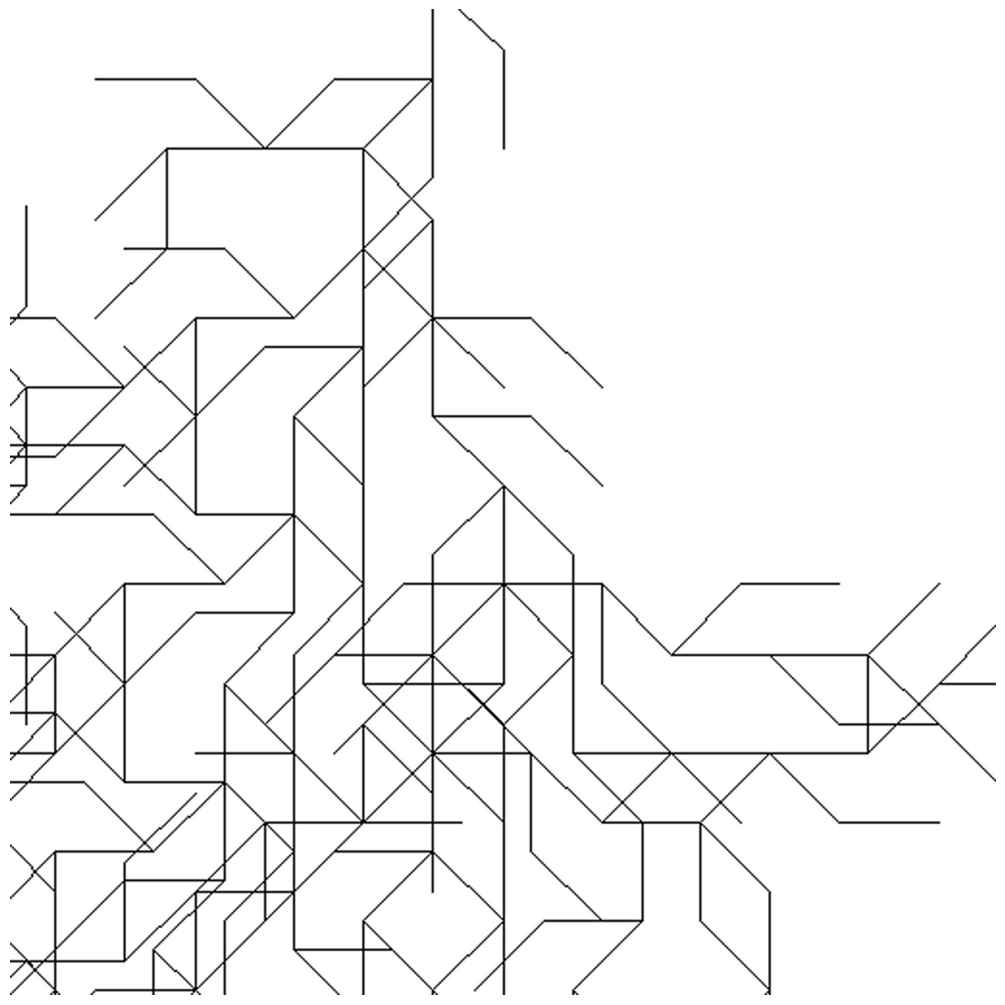

In [23]:
# inspired by my previous work on fractal generation : https://github.com/VendenIX/Generateur-de-flore-video-ludique
def generate_fractal_template(small_img_size=512, final_img_size=1280, iterations=5, angle=45, length_factor=10, rate=50):
    axiom = "F"
    rules = {
        "F": "1F+[+X-F]X-[-F+X]X",
        "X": "[-F+F]F[-F+F]"
    }
    optional_rule = ("X", "[-]")  # règle optionnelle avec 50 % de chance
    length = small_img_size / length_factor  # longueur ajustée pour l'image 512x512

    def apply_rules(axiom, rules, optional_rule, rate, iterations):
        for _ in range(iterations):
            new_axiom = ""
            for char in axiom:
                if char in rules:
                    if char == optional_rule[0] and random.randint(0, 100) < rate:
                        new_axiom += optional_rule[1]
                    else:
                        new_axiom += rules[char]
                else:
                    new_axiom += char
            axiom = new_axiom
        return axiom

    def draw_lsystem(axiom, angle, length, img_size):
        stack = []
        x, y = img_size // 2, -int(img_size * 0.2) 
        current_angle = 90
        img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255 

        for command in axiom:
            if command == "F" or command == "X":
                new_x = x + length * cos(radians(current_angle))
                new_y = y + length * sin(radians(current_angle))
                cv2.line(img, (int(x), int(y)), (int(new_x), int(new_y)), (0, 0, 0), 1) 
                x, y = new_x, new_y
            elif command == "+":
                current_angle += angle
            elif command == "-":
                current_angle -= angle
            elif command == "[":
                stack.append((x, y, current_angle))
            elif command == "]":
                x, y, current_angle = stack.pop()

        return img

    final_axiom = apply_rules(axiom, rules, optional_rule, rate, iterations)
    small_img = draw_lsystem(final_axiom, angle, length, small_img_size)

    final_img = cv2.resize(small_img, (final_img_size, final_img_size), interpolation=cv2.INTER_CUBIC)

    return final_img

template_image = generate_fractal_template()

plt.figure(figsize=(12.8, 12.8))
plt.axis("off")
plt.imshow(cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB))
plt.show()

In [89]:
# config du dataset
dataset_dir = "custom_generated_dataset_yolo_with_lines"
images_dir = os.path.join(dataset_dir, "images")
labels_dir = os.path.join(dataset_dir, "labels")

# création des sous-dossiers pour train, val et test
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

# paramètres de generation
num_imgs = 500
img_size = 1280
min_object_size = 30
max_object_size = 80
num_objects_per_image = 50#np.random.randint(25, 60)

shape_to_class_id = {
    "homme": 0, "femme": 1, "homme decede": 2, "femme decede": 3,
    "homme atteint decede": 4, "femme atteinte decedee": 5,
    "index": 6, "homme atteint": 7, "femme atteinte": 8
}

def draw_bounding_box(class_id, x, y, size, img_size):
    x_center = (x + size / 2) / img_size
    y_center = (y + size / 2) / img_size
    width    = size / img_size
    height   = size / img_size
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def rotate_shape(image, center, angle):
    h, w            = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated         = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return rotated

def draw_rotated_rectangle(image, x, y, size, color, angle, fill=True):
    # limite de la taille pour éviter des rectangles anormalement grands
    max_size = min(image.shape[0], image.shape[1]) // 5  # 1/5 de la taille de l'image
    size = min(size, max_size)

    # Créer un rectangle avec un fond blanc
    rectangle = np.ones_like(image) * 255
    thickness = -1 if fill else 2  # -1 pour remplir, 2 pour les contours uniquement

    # Dessiner le rectangle avec ou sans remplissage
    cv2.rectangle(rectangle, (x, y), (x + size, y + size), color, thickness)

    # Calcul du centre pour la rotation
    center = (x + size // 2, y + size // 2)
    rotated_rectangle = rotate_shape(rectangle, center, angle)

    # Appliquer le rectangle tourné sur l'image
    image = cv2.bitwise_and(image, rotated_rectangle)
    return image

def draw_arrow(length=100, width=40, angle=0, output_size=256):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
    ax.set_xlim(-output_size // 2, output_size // 2)
    ax.set_ylim(-output_size // 2, output_size // 2)
    ax.axis('off')

    x_start, y_start = 0, 0
    x_end = length * np.cos(np.radians(angle))
    y_end = length * np.sin(np.radians(angle))

    arrow = ax.arrow(
        x_start, y_start, x_end, y_end,
        head_width=width * 2,      # Tête large
        head_length=width * 1.5,   # Queue raccourcie
        fc="black", ec="black", linewidth=width * 0.8
    )
    arrow.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="white")])

    buf = BytesIO()
    plt.savefig(buf, format='png', transparent=True)
    buf.seek(0)
    arrow_img = Image.open(buf).convert('RGBA')
    buf.close()
    plt.close(fig)

    arrow_img = arrow_img.resize((output_size, output_size), Image.LANCZOS)
    arrow_img = np.array(arrow_img)

    mask = (arrow_img[:, :, 3] > 0) & ((arrow_img[:, :, :3] != [255, 255, 255]).any(axis=2))
    img_rgb = np.ones((output_size, output_size, 3), dtype=np.uint8) * 255
    img_rgb[mask] = [0, 0, 0]
    
    return img_rgb, mask

def draw_rotated_arrow(image, x, y, length=100, width=40, angle=0, output_size=256):
    arrow_image, mask = draw_arrow(length=length, width=width, angle=angle, output_size=output_size)
    arrow_h, arrow_w = arrow_image.shape[:2]
    if x + arrow_w > image.shape[1]:
        x = image.shape[1] - arrow_w
    if y + arrow_h > image.shape[0]:
        y = image.shape[0] - arrow_h

    overlay_region = image[y:y + arrow_h, x:x + arrow_w]
    overlay_region[mask] = arrow_image[mask]
    image[y:y + arrow_h, x:x + arrow_w] = overlay_region

    non_white_pixels = np.argwhere(mask)
    y_min, x_min = non_white_pixels.min(axis=0)
    y_max, x_max = non_white_pixels.max(axis=0)

    box_x_center = (x + (x_min + x_max) / 2) / image.shape[1]
    box_y_center = (y + (y_min + y_max) / 2) / image.shape[0]
    box_width_norm = (x_max - x_min) / image.shape[1]
    box_height_norm = (y_max - y_min) / image.shape[0]
    
    return image, f"6 {box_x_center:.6f} {box_y_center:.6f} {box_width_norm:.6f} {box_height_norm:.6f}"

def create_image_with_custom_shapes(img_size, num_objects, min_size, max_size):
    image = generate_fractal_template()
    if not isinstance(image, np.ndarray):
        raise TypeError("generate_fractal_template() doit renvoyer un tableau NumPy représentant une image.")
    annotations = []
    centers = []
    for _ in range(num_objects):
        shape_type = np.random.choice(list(shape_to_class_id.keys()))
        size = np.random.randint(min_size, max_size)
        x = np.random.randint(0, img_size - size)
        y = np.random.randint(0, img_size - size)
        angle = np.random.randint(0, 360)
        if shape_type == "index":
            length = np.random.randint(25, 50)
            width = np.random.randint(5, 10)
            image, annotation = draw_rotated_arrow(image, x, y, length=length, width=width, angle=angle, output_size=128)
            annotations.append(annotation)
            
        elif shape_type == "homme":
            image = draw_rotated_rectangle(image, x, y, size, (0, 0, 0), angle, fill=False)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "femme":
            circle = np.ones_like(image, dtype=np.uint8) * 255
            cv2.circle(circle, (x + size // 2, y + size // 2), size // 2, (0, 0, 0), 2)
            rotated_circle = rotate_shape(circle, (x + size // 2, y + size // 2), angle)
            image = cv2.bitwise_and(image, rotated_circle)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "homme decede":
            image = draw_rotated_rectangle(image, x, y, size, (0, 0, 0), angle, fill=False)
            cv2.line(image, (x, y), (x + size, y + size), (0, 0, 0), 2)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "femme decede":
            circle = np.ones_like(image, dtype=np.uint8) * 255
            radius = size // 2
            center = (x + radius, y + radius)
            cv2.circle(circle, center, radius, (0, 0, 0), 2)
            rotated_circle = rotate_shape(circle, center, angle)
            image = cv2.bitwise_and(image, rotated_circle)
            random_factor = np.random.uniform(1.6, 1.9)
            line_length = int(radius * random_factor)
            start_point = (center[0] - line_length // 2, center[1] - line_length // 2)
            end_point = (center[0] + line_length // 2, center[1] + line_length // 2)
            cv2.line(image, start_point, end_point, (0, 0, 0), 2)
            centers.append(center)

        elif shape_type == "homme atteint decede":
            image = draw_rotated_rectangle(image, x, y, size, (0, 0, 255), angle)
            cv2.line(image, (x, y), (x + size, y + size), (0, 0, 0), 2)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "femme atteinte decedee":
            circle = np.ones_like(image, dtype=np.uint8) * 255
            cv2.circle(circle, (x + size // 2, y + size // 2), size // 2, (255, 0, 0), -1)
            rotated_circle = rotate_shape(circle, (x + size // 2, y + size // 2), angle)
            image = cv2.bitwise_and(image, rotated_circle)
            cv2.line(image, (x, y), (x + size, y + size), (0, 0, 0), 2)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "homme atteint":
            image = draw_rotated_rectangle(image, x, y, size, (0, 255, 0), angle)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "femme atteinte":
            circle = np.ones_like(image, dtype=np.uint8) * 255
            cv2.circle(circle, (x + size // 2, y + size // 2), size // 2, (0, 255, 0), -1)
            rotated_circle = rotate_shape(circle, (x + size // 2, y + size // 2), angle)
            image = cv2.bitwise_and(image, rotated_circle)
            centers.append((x + size // 2, y + size // 2))
        class_id = shape_to_class_id[shape_type]
        if shape_type != "index":
            annotations.append(draw_bounding_box(class_id, x, y, size, img_size))
    noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
    image = cv2.add(image, noise)
    return image, annotations

# generer les images et annotations YOLO
for i in range(num_imgs):
    img, img_annotations = create_image_with_custom_shapes(img_size, num_objects_per_image, min_object_size, max_object_size)
    img_name = f"img_{i}.png"
    label_name = f"img_{i}.txt"
    
    # save l'image
    cv2.imwrite(os.path.join(images_dir, img_name), img)
    
    # save les annotations au format YOLO
    with open(os.path.join(labels_dir, label_name), 'w') as f:
        f.write("\n".join(img_annotations))

# diviser les images en train, validation et test
all_images = [f"img_{i}.png" for i in range(num_imgs)]
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

# déplacer les fichiers dans les sous-dossiers appropriés
for img_set, split in zip([train_images, val_images, test_images], ["train", "val", "test"]):
    for img_name in img_set:
        # copier les images
        src_img_path = os.path.join(images_dir, img_name)
        dest_img_path = os.path.join(images_dir, split, img_name)
        os.replace(src_img_path, dest_img_path)
        
        # copier les labels correspondants
        label_name = img_name.replace(".png", ".txt")
        src_label_path = os.path.join(labels_dir, label_name)
        dest_label_path = os.path.join(labels_dir, split, label_name)
        os.replace(src_label_path, dest_label_path)

# création du fichier de configuration YAML pour YOLO
config_data = {
    'train': os.path.join(images_dir, 'train'),
    'val': os.path.join(images_dir, 'val'),
    'test': os.path.join(images_dir, 'test'),
    'names': {class_id: class_name for class_name, class_id in shape_to_class_id.items()}
}

with open("config.yaml", 'w') as yaml_file:
    yaml.dump(config_data, yaml_file, default_flow_style=False)

print("Dataset YOLO format with 9 classes, individual rotations, and simulated genealogical lines generated successfully!")
print("Configuration YAML file created as 'config.yaml'")

Dataset YOLO format with 9 classes, individual rotations, and simulated genealogical lines generated successfully!
Configuration YAML file created as 'config.yaml'


#### Affichage de la première image du dataset de validation 

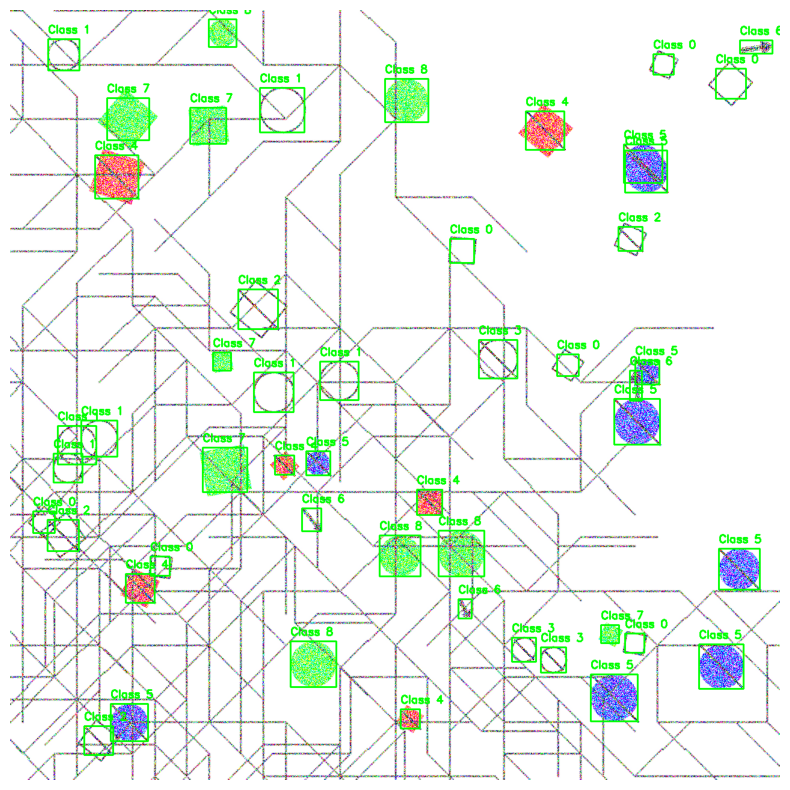

In [92]:
dataset_dir = "custom_generated_dataset_yolo_with_lines"
images_dir = os.path.join(dataset_dir, "images", "val")
labels_dir = os.path.join(dataset_dir, "labels", "val")

image_files = sorted(os.listdir(images_dir))
first_image_path = os.path.join(images_dir, image_files[0])
first_image = cv2.imread(first_image_path)

annotation_file = os.path.join(labels_dir, image_files[0].replace(".png", ".txt"))

with open(annotation_file, 'r') as f:
    annotations = f.readlines()

# parcourir les annotations et dessiner les boîtes de délimitation sur l'image
for annotation in annotations:
    class_id, x_center, y_center, width, height = map(float, annotation.split())
    
    # recup des coordonnées de la boîte en pixels
    img_h, img_w = first_image.shape[:2]
    box_x_center = int(x_center * img_w)
    box_y_center = int(y_center * img_h)
    box_width = int(width * img_w)
    box_height = int(height * img_h)

    # calcul des coins supérieurs gauche et inférieur droit de la boîte
    top_left = (box_x_center - box_width // 2, box_y_center - box_height // 2)
    bottom_right = (box_x_center + box_width // 2, box_y_center + box_height // 2)

    color = (0, 255, 0)  
    cv2.rectangle(first_image, top_left, bottom_right, color, 2)
    cv2.putText(first_image, f"Class {int(class_id)}", (top_left[0], top_left[1] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

first_image_rgb = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(first_image_rgb)
plt.show()

In [91]:
config_path = 'config.yaml' 
analyzer = DatasetAnalyzer(config_path)
analyzer.analyze_dataset()
analyzer.display_stats()

Statistiques du dataset :

Train set:
  Taille moyenne des images : 1280.0 x 1280.0
  Nombre total d'images : 400
  Nombre total d'individus dans toutes les classes : 20000
  Nombre d'individus par classe :
    Classe homme : 2248
    Classe femme : 2212
    Classe homme decede : 2191
    Classe femme decede : 2241
    Classe homme atteint decede : 2154
    Classe femme atteinte decedee : 2272
    Classe index : 2228
    Classe homme atteint : 2273
    Classe femme atteinte : 2181

Val set:
  Taille moyenne des images : 1280.0 x 1280.0
  Nombre total d'images : 50
  Nombre total d'individus dans toutes les classes : 2500
  Nombre d'individus par classe :
    Classe homme : 241
    Classe femme : 278
    Classe homme decede : 295
    Classe femme decede : 254
    Classe homme atteint decede : 297
    Classe femme atteinte decedee : 278
    Classe index : 272
    Classe homme atteint : 266
    Classe femme atteinte : 319

Test set:
  Taille moyenne des images : 1280.0 x 1280.0
  Nombre t

## Creating Realistic arrows

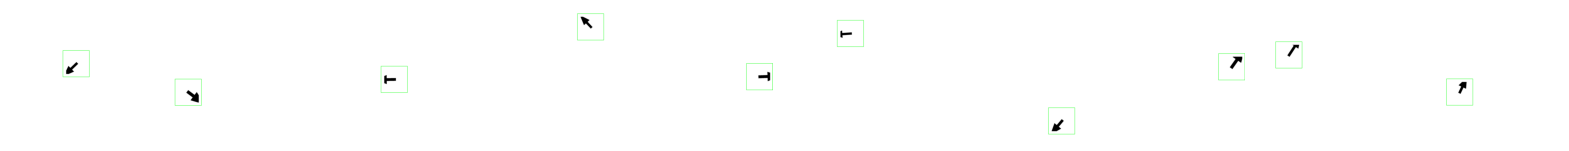

In [19]:


# Configuration du dataset
dataset_dir = "custom_generated_dataset_yolo_with_thick_arrows"
images_dir = os.path.join(dataset_dir, "images")
labels_dir = os.path.join(dataset_dir, "labels")

# Création des sous-dossiers pour train, val et test
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

# Dessine une flèche avec un remplissage noir
def draw_handdrawn_arrow(length=100, width=40, angle=0, output_size=256):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
    ax.set_xlim(-output_size//2, output_size//2)
    ax.set_ylim(-output_size//2, output_size//2)
    ax.axis('off')

    # Coordonnées de la flèche
    x_start, y_start = 0, 0
    x_end = length * np.cos(np.radians(angle))
    y_end = length * np.sin(np.radians(angle))

    # Flèche avec tête large et corps noir
    ax.arrow(
        x_start, y_start, x_end, y_end,
        head_width=width * 1.5, head_length=width * 2,
        fc="black", ec="black", linewidth=0  # Corps noir sans bordure
    )

    # Conversion de la figure Matplotlib en image OpenCV
    buf = BytesIO()
    plt.savefig(buf, format='png', transparent=True)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')
    img = np.array(img)
    buf.close()
    plt.close(fig)

    # Appliquer le remplissage noir
    img[img[:, :, 0] < 255] = [0, 0, 0]  # Remplir les pixels non-blancs en noir

    img_resized = cv2.resize(img, (output_size, output_size), interpolation=cv2.INTER_AREA)
    return img_resized

def create_test_images_with_handdrawn_arrows(num_images=10, img_size=1280, arrow_size=256):
    images = []
    for _ in range(num_images):
        # Créer une image blanche de fond
        image = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255

        # Générer une flèche épaisse dessinée à main levée
        length = np.random.randint(80, 150)  # Réduire la longueur pour une queue plus courte
        width = np.random.randint(30, 50)    # Largeur augmentée pour un effet épais
        angle = np.random.randint(0, 360)
        arrow_image = draw_handdrawn_arrow(length=length, width=width, angle=angle, output_size=arrow_size)

        # S'assurer que la flèche ne dépasse pas les limites de l'image
        if arrow_image.shape[0] > img_size or arrow_image.shape[1] > img_size:
            arrow_image = cv2.resize(arrow_image, (img_size//4, img_size//4))

        # Calculer les positions aléatoires pour la flèche
        arrow_x = np.random.randint(0, img_size - arrow_image.shape[1])
        arrow_y = np.random.randint(0, img_size - arrow_image.shape[0])

        # Superposer l'image de la flèche sur le fond
        image[arrow_y:arrow_y + arrow_image.shape[0], arrow_x:arrow_x + arrow_image.shape[1]] = arrow_image

        # Calculer les coordonnées pour la bounding box et les dessiner
        box_x1, box_y1 = arrow_x, arrow_y
        box_x2, box_y2 = arrow_x + arrow_image.shape[1], arrow_y + arrow_image.shape[0]
        cv2.rectangle(image, (box_x1, box_y1), (box_x2, box_y2), (0, 255, 0), 2)  # Bounding box en vert

        images.append(image)
    return images

# Générer et afficher les images de test
test_images = create_test_images_with_handdrawn_arrows(num_images=10, img_size=img_size)

plt.figure(figsize=(20, 5))
for i, img in enumerate(test_images):
    plt.subplot(1, 10, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

Dataset YOLO format with 9 classes, individual rotations, and simulated genealogical lines generated successfully!
Configuration YAML file created as 'config.yaml'


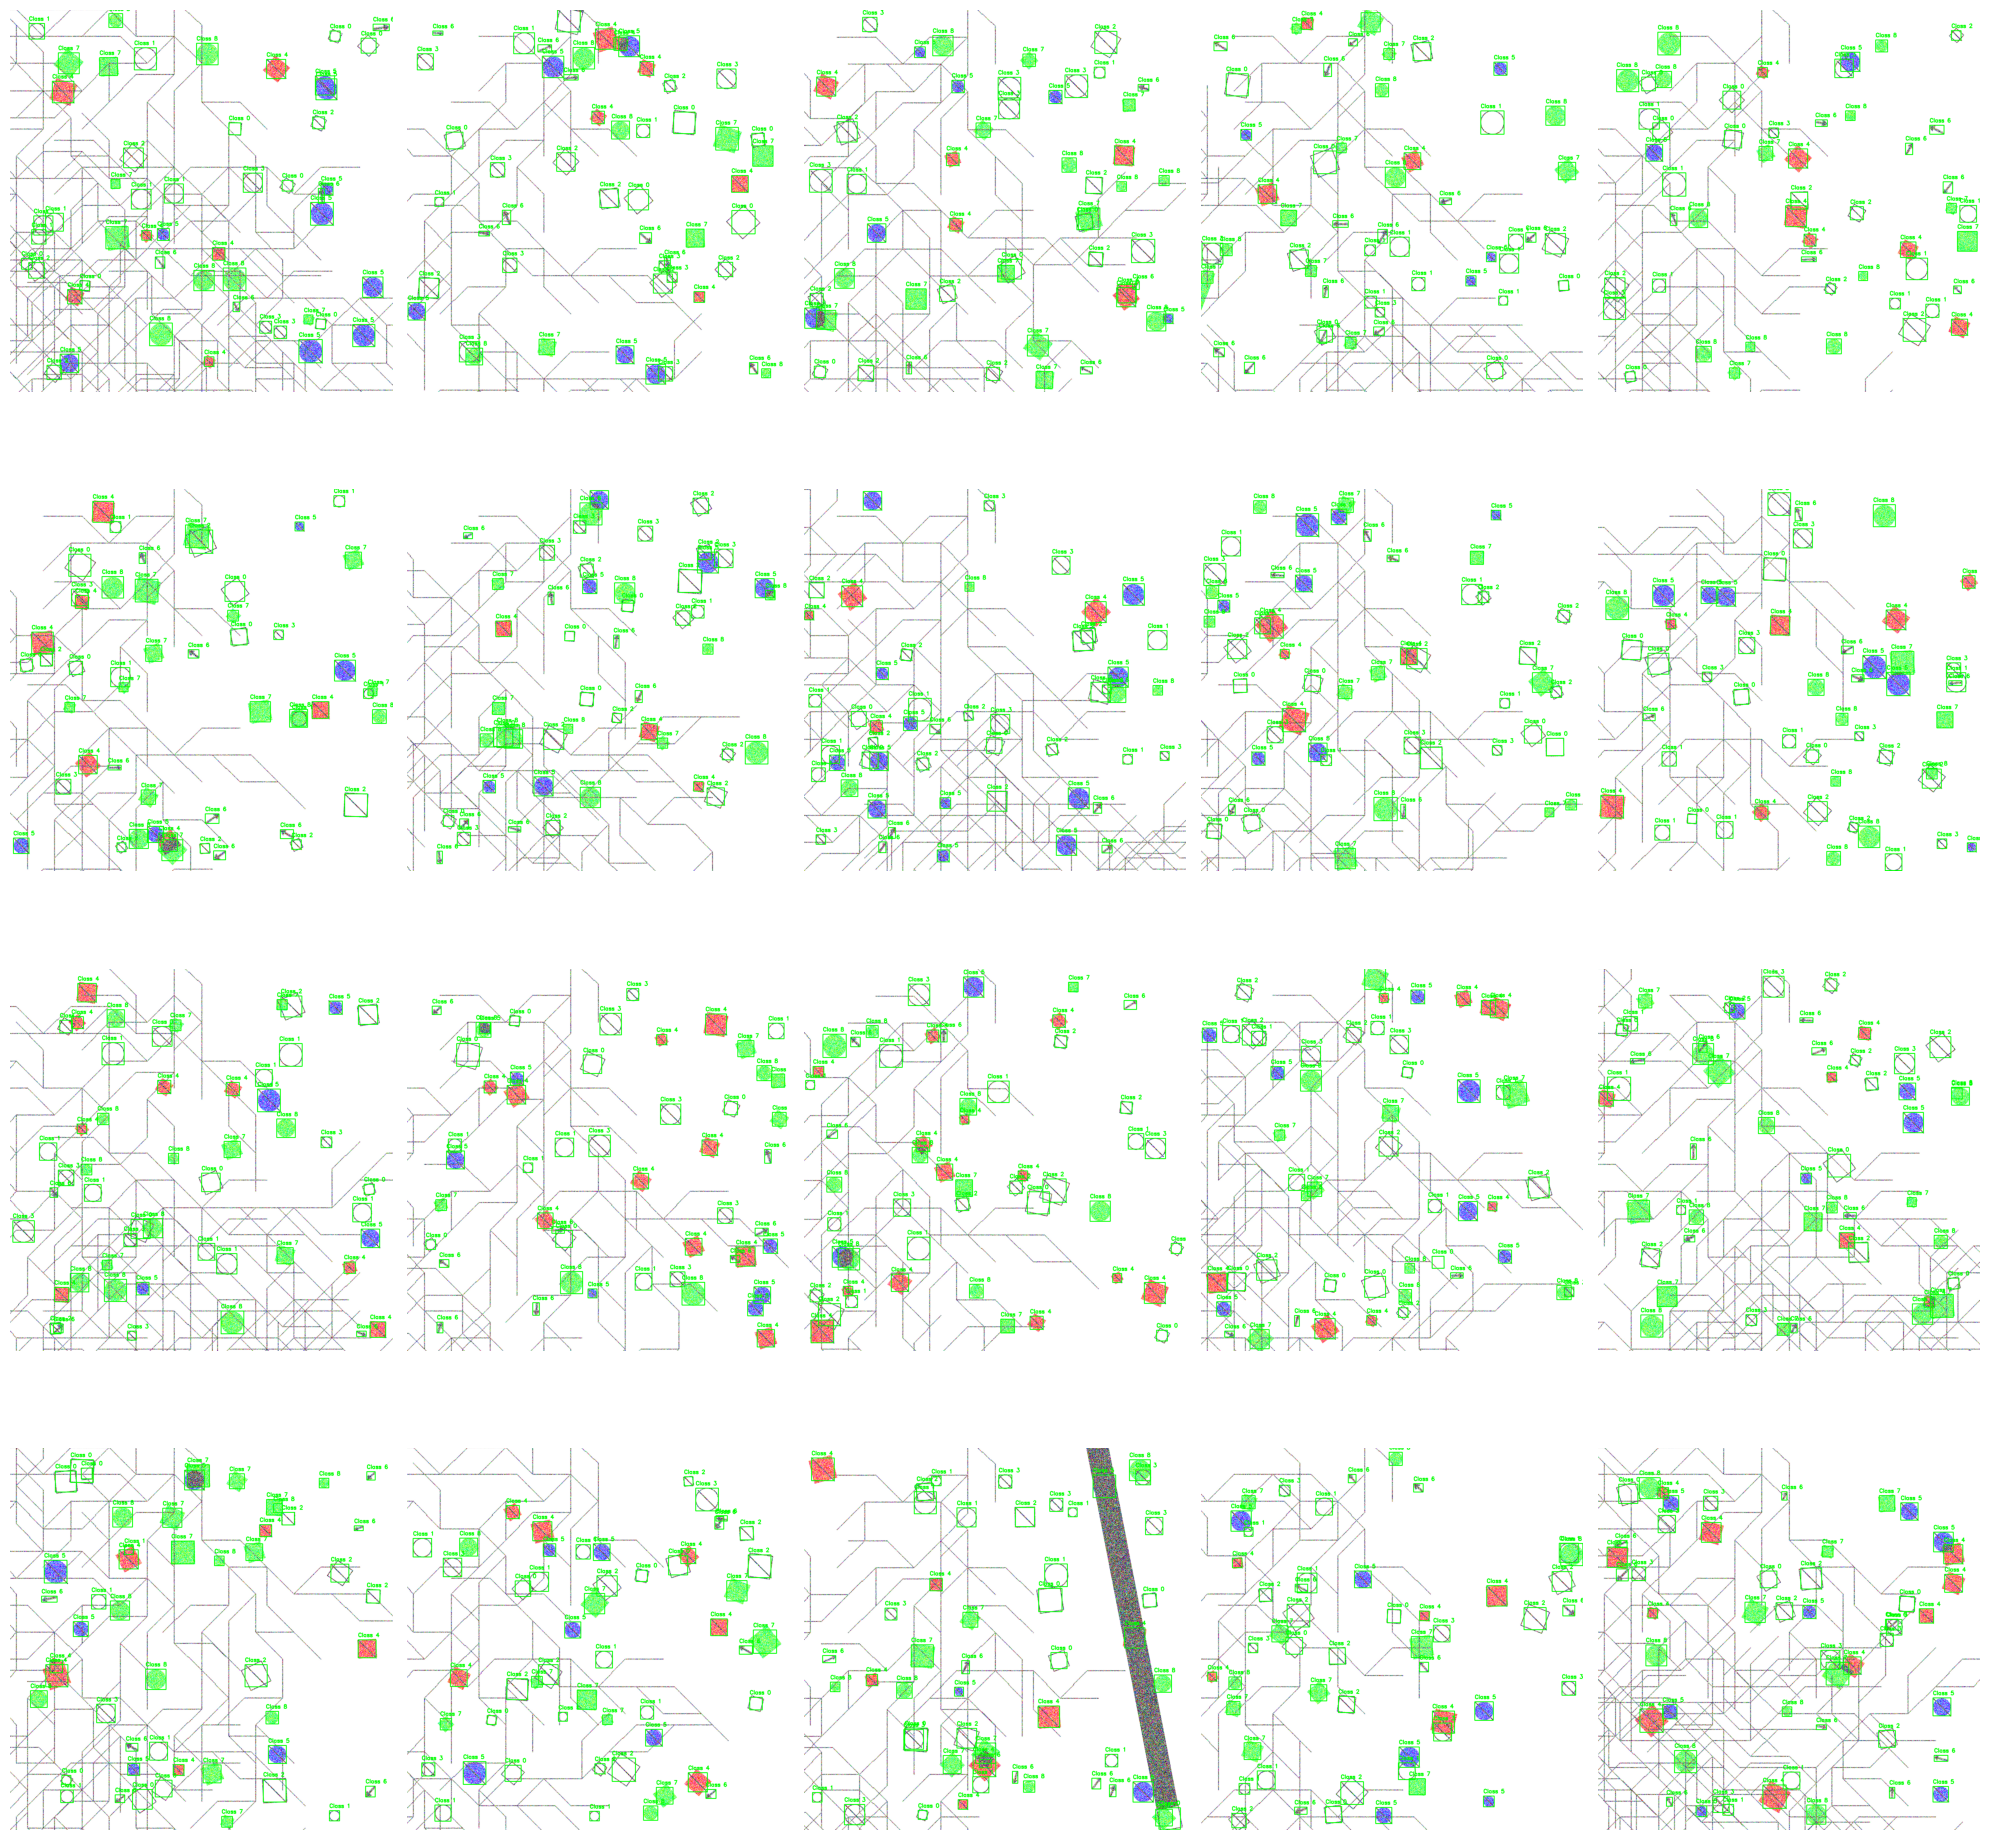

In [94]:
import os
import cv2
import matplotlib.pyplot as plt

dataset_dir = "custom_generated_dataset_yolo_with_lines"
images_dir = os.path.join(dataset_dir, "images", "val")
labels_dir = os.path.join(dataset_dir, "labels", "val")

# Charger et trier les images
image_files = sorted(os.listdir(images_dir))[:20]  # Limiter aux 20 premières images

# Parcourir les 20 premières images
plt.figure(figsize=(20, 20))
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)
    annotation_file = os.path.join(labels_dir, image_file.replace(".png", ".txt"))
    
    # Lire les annotations et dessiner les boîtes de délimitation
    with open(annotation_file, 'r') as f:
        annotations = f.readlines()
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        
        # Récupérer les coordonnées de la boîte en pixels
        img_h, img_w = image.shape[:2]
        box_x_center = int(x_center * img_w)
        box_y_center = int(y_center * img_h)
        box_width = int(width * img_w)
        box_height = int(height * img_h)

        # Calculer les coins supérieurs gauche et inférieur droit de la boîte
        top_left = (box_x_center - box_width // 2, box_y_center - box_height // 2)
        bottom_right = (box_x_center + box_width // 2, box_y_center + box_height // 2)

        color = (0, 255, 0)  
        cv2.rectangle(image, top_left, bottom_right, color, 2)
        cv2.putText(image, f"Class {int(class_id)}", (top_left[0], top_left[1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Convertir en RGB pour affichage avec matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Afficher chaque image
    plt.subplot(4, 5, idx + 1)
    plt.imshow(image_rgb)
    plt.axis("off")

plt.tight_layout()
plt.show()

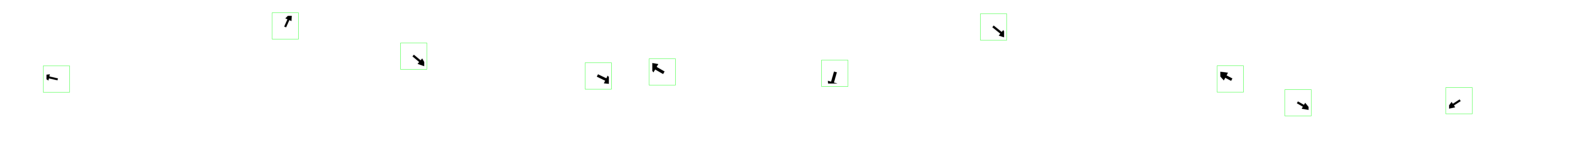

In [45]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
import yaml
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from io import BytesIO
from PIL import Image

dataset_dir = "custom_generated_dataset_yolo_with_thick_arrows"
images_dir = os.path.join(dataset_dir, "images")
labels_dir = os.path.join(dataset_dir, "labels")

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

def draw_handdrawn_arrow(length=100, width=40, angle=0, output_size=256):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
    ax.set_xlim(-output_size//2, output_size//2)
    ax.set_ylim(-output_size//2, output_size//2)
    ax.axis('off')  

    x_start, y_start = 0, 0
    x_end = length * np.cos(np.radians(angle))
    y_end = length * np.sin(np.radians(angle))

    arrow = ax.arrow(
        x_start, y_start, x_end, y_end,
        head_width=width * 1.5,  
        head_length=width * 2,  
        fc="black", ec="black", linewidth=width * 0.7 
    )
    pe = [PathEffects.withStroke(linewidth=3, foreground="white")]
    arrow.set_path_effects(pe)

    buf = BytesIO()
    plt.savefig(buf, format='png', transparent=True)
    buf.seek(0)
    img = Image.open(buf)
    img = img.convert('RGB')
    img = np.array(img)
    buf.close()
    plt.close(fig)

    img_resized = cv2.resize(img, (output_size, output_size), interpolation=cv2.INTER_AREA)
    return img_resized

def create_test_images_with_handdrawn_arrows(num_images=10, img_size=1280, arrow_size=256):
    images = []
    for _ in range(num_images):
        image = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255

        length = np.random.randint(80, 150) 
        width = np.random.randint(30, 50)   
        angle = np.random.randint(0, 360)
        arrow_image = draw_handdrawn_arrow(length=length, width=width, angle=angle, output_size=arrow_size)

        if arrow_image.shape[0] > img_size or arrow_image.shape[1] > img_size:
            arrow_image = cv2.resize(arrow_image, (img_size//4, img_size//4))

        arrow_x = np.random.randint(0, img_size - arrow_image.shape[1])
        arrow_y = np.random.randint(0, img_size - arrow_image.shape[0])

        image[arrow_y:arrow_y + arrow_image.shape[0], arrow_x:arrow_x + arrow_image.shape[1]] = arrow_image

        box_x1, box_y1 = arrow_x, arrow_y
        box_x2, box_y2 = arrow_x + arrow_image.shape[1], arrow_y + arrow_image.shape[0]
        cv2.rectangle(image, (box_x1, box_y1), (box_x2, box_y2), (0, 255, 0), 2)  

        images.append(image)
    return images

test_images = create_test_images_with_handdrawn_arrows(num_images=10, img_size=img_size)

plt.figure(figsize=(20, 5))
for i, img in enumerate(test_images):
    plt.subplot(1, 10, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

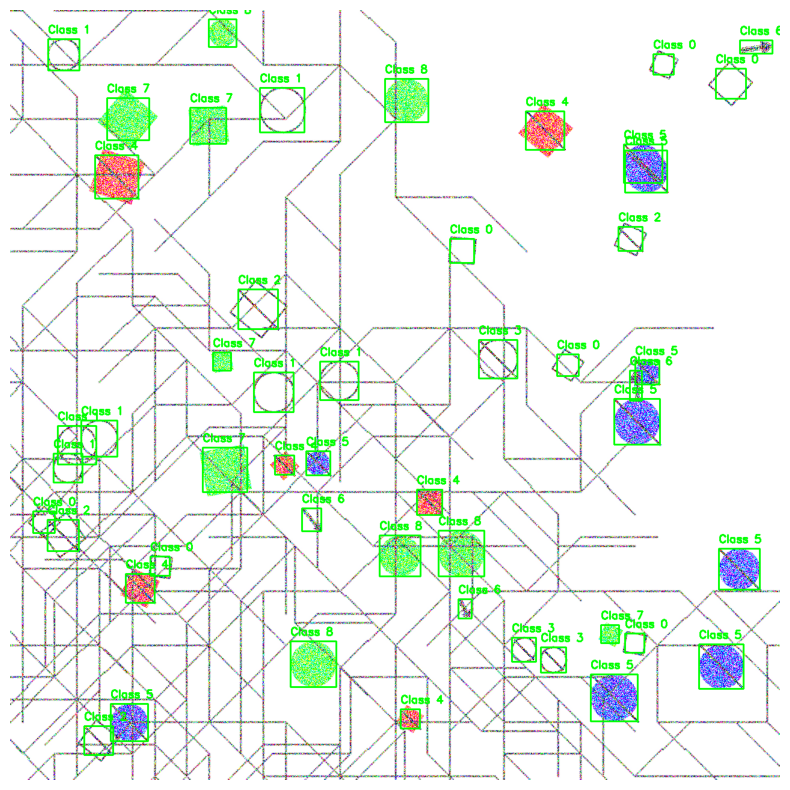

In [95]:
dataset_dir = "custom_generated_dataset_yolo_with_lines"
images_dir = os.path.join(dataset_dir, "images", "val")
labels_dir = os.path.join(dataset_dir, "labels", "val")

image_files = sorted(os.listdir(images_dir))
first_image_path = os.path.join(images_dir, image_files[0])
first_image = cv2.imread(first_image_path)

annotation_file = os.path.join(labels_dir, image_files[0].replace(".png", ".txt"))

with open(annotation_file, 'r') as f:
    annotations = f.readlines()

# parcourir les annotations et dessiner les boîtes de délimitation sur l'image
for annotation in annotations:
    class_id, x_center, y_center, width, height = map(float, annotation.split())
    
    # recup des coordonnées de la boîte en pixels
    img_h, img_w = first_image.shape[:2]
    box_x_center = int(x_center * img_w)
    box_y_center = int(y_center * img_h)
    box_width = int(width * img_w)
    box_height = int(height * img_h)

    # calcul des coins supérieurs gauche et inférieur droit de la boîte
    top_left = (box_x_center - box_width // 2, box_y_center - box_height // 2)
    bottom_right = (box_x_center + box_width // 2, box_y_center + box_height // 2)

    color = (0, 255, 0)  
    cv2.rectangle(first_image, top_left, bottom_right, color, 2)
    cv2.putText(first_image, f"Class {int(class_id)}", (top_left[0], top_left[1] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

first_image_rgb = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(first_image_rgb)
plt.show()